In [1]:
%matplotlib inline
from keras.models import Model
from keras.layers import Input, merge
import cv2 as cv
import numpy as np
from pandas.io.parsers import read_csv
import os
from sklearn.utils import shuffle
from keras.callbacks import LearningRateScheduler, LambdaCallback
import time
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import AtrousConvolution2D
from keras.layers.core import Dense,Dropout,Flatten,Activation
from keras import  models
import keras.models 
import keras
import matplotlib.pyplot as plt
from keras.layers.normalization import  BatchNormalization
from keras.regularizers import l2, activity_l2
from keras.models import Sequential, load_model
from keras.layers import advanced_activations
from keras.optimizers import *
from keras.layers.advanced_activations import *
from skimage.transform import rotate
import pandas as pd
from sklearn.externals import joblib
import skimage

Using Theano backend.
Using gpu device 0: GeForce GT 755M (CNMeM is disabled, cuDNN 5105)


In [2]:
FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'CSVs/IdLookupTable.csv'

       
def make_submission(test_labels):
    test_labels *= 48.0
    test_labels += 48.0
    test_labels = test_labels.clip(0, 96)

    lookup_table = pd.read_csv(FLOOKUP)
    values = []

    cols = joblib.load('cols.pkl')

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            test_labels[row.ImageId - 1][np.where(cols == row.FeatureName)[0][0]],
            ))
    submission = pd.DataFrame(values, columns=('RowId', 'Location'))
    submission.to_csv('CSVs/submission.csv', index=False)
    
def load(test=False, cols=None):
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)  
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    if cols:  
        df = df[list(cols) + ['Image']]
    cols_l = df.columns[:-1]
    print(df.count())  
    df = df.dropna()
    X = np.vstack(df['Image'].values) /255 
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
#         joblib.dump(cols_l, 'cols.pkl', compress=3)
    else:
        y = None
    return X, y

# cols=['left_eye_center_x',
#       'left_eye_center_y',
      
      
#       'right_eye_center_x',
#       'right_eye_center_y',
      
#       'left_eye_inner_corner_x',
#       'left_eye_inner_corner_y',
#       'left_eye_outer_corner_x',
#       'left_eye_outer_corner_y', 
#       'right_eye_inner_corner_x',
#       'right_eye_inner_corner_y', 
#       'right_eye_outer_corner_x',
#       'right_eye_outer_corner_y',
#       'left_eyebrow_inner_end_x', 
#       'left_eyebrow_inner_end_y', 
#       'left_eyebrow_outer_end_x', 
#       'left_eyebrow_outer_end_y', 
#       'right_eyebrow_inner_end_x',
#       'right_eyebrow_inner_end_y',
#       'right_eyebrow_outer_end_x',
#       'right_eyebrow_outer_end_y',
      
#       'nose_tip_x',
#       'nose_tip_y',
#       'mouth_left_corner_x', 
#       'mouth_left_corner_y', 
#       'mouth_right_corner_x',
#       'mouth_right_corner_y',
#        'mouth_center_top_lip_x',
#       'mouth_center_top_lip_y',
#       'mouth_center_bottom_lip_x',
#       'mouth_center_bottom_lip_y']

cols=['left_eye_center_x',
      'left_eye_center_y',
      'right_eye_center_x',
      'right_eye_center_y',
      'nose_tip_x',
      'nose_tip_y',
      'mouth_center_bottom_lip_x',
      'mouth_center_bottom_lip_y']

X, y = load(cols=cols)
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
nose_tip_x                   7049
nose_tip_y                   7049
mouth_center_bottom_lip_x    7016
mouth_center_bottom_lip_y    7016
Image                        7049
dtype: int64
X.shape == (7000, 9216); X.min == 0.000; X.max == 1.000
y.shape == (7000, 8); y.min == -0.986; y.max == 0.996


In [3]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

def flip (x,y):
    x=x.reshape(-1,96,96)
    y=y.reshape(y.shape[0],-1)
    xx=x.copy()
    yy=y.copy()
    for i in range (xx.shape[0]):
        xx[i]=np.fliplr(x[i])
    ran=range(0,yy.shape[1],2)
    yy[:,ran]*=-1
    temp=yy[:,0:2].copy()
    temp2=yy[:,2:4].copy()
    yy[:,0:2]=temp2
    yy[:,2:4]=temp
    return xx.reshape(-1,9216),yy

def augment_noise (x,y):
    xx=x.copy()
    yy=y.copy()
    xx=xx.reshape(-1,96,96)
    yy=yy.reshape(x.shape[0],-1)
    
    for i in range (x.shape[0]):
        xx[i] = skimage.util.random_noise(xx[i], mode='gaussian', clip=True)
        xx[i] = skimage.util.random_noise(xx[i], mode='s&p', clip=True, amount=0.01)
    
    return xx.reshape(-1,9216),yy
def  blur (x,y):
    x=x.reshape(-1,96,96)
    y=y.reshape(x.shape[0],-1)
    xx=x.copy()
    yy=y.copy()
    for i in range (x.shape[0]):
        kernel = np.ones((7,7),np.float32)/49
        xx[i] = cv.filter2D(x[i],-1,kernel)

    return xx.reshape(-1,9216),yy
def augment_rotate(X, y):
    rotated_X = np.zeros_like(X)
    rotated_y = np.zeros_like(y)
    for i in range(X.shape[0]):
        img = X[i].reshape((96,96))/255.0
        labels = y[i]
        angle = np.random.randint(low=-10, high=10) * (np.pi/180.0)
        for j in np.arange(0, labels.shape[0], 2):
            R = np.sqrt(labels[j]**2 + labels[j+1]**2)
            theta = np.arctan2(labels[j+1], labels[j])
            rotated_y[i][j] = R * np.cos(theta - angle)
            rotated_y[i][j+1] = R * np.sin(theta - angle)
        rotated_X[i] = rotate(img, angle*(180/np.pi)).reshape((96*96,)) * 255
    return rotated_X, rotated_y
augment_noise_x,augment_noise_y=augment_noise(X,y)
augment_rotate_x,augment_rotate_y=augment_rotate(X,y)
flip_x,flip_y=flip(X,y)
flipped_rotated_x,flipped_rotated_y=flip(augment_rotate_x,augment_rotate_y)
blur_x,blur_y=blur(X,y)

all_x=np.concatenate((X,augment_rotate_x,flip_x,flipped_rotated_x,blur_x),axis=0)
all_y=np.concatenate((y,augment_rotate_y,flip_y,flipped_rotated_y,blur_y),axis=0)

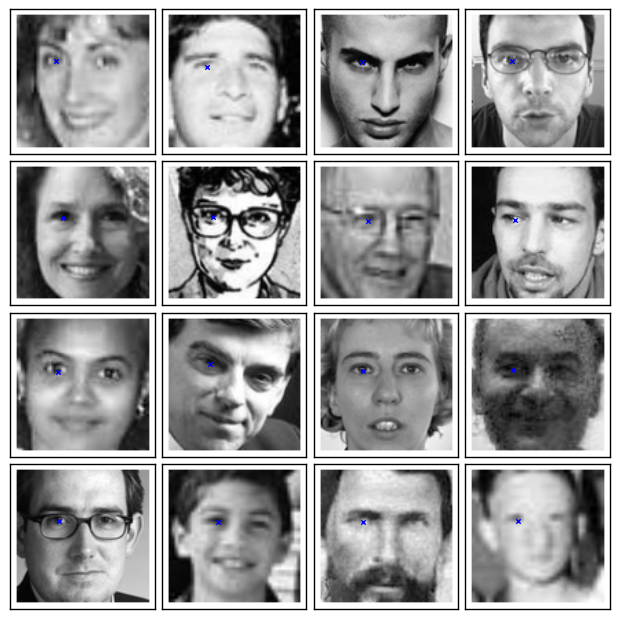

In [4]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)   


for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(all_x[i],all_y[i][2:4], ax)

In [5]:
def build_model():
    model = Sequential()
    
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same',
                            input_shape=(1,96, 96)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D(32, 3, 3, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D(16, 1, 1, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
        
    model.add(Convolution2D(8, 1, 1, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))

    model.add(Dense(8, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(Activation('linear'))
    return model

In [6]:
def build_model2():
    inn = Input(shape=(1,96, 96))
    branch1 = Convolution2D(32, 3, 3,init = 'glorot_uniform', W_regularizer = l2(3e-4), border_mode="same")(inn)
    branch1=BatchNormalization()(branch1)
    branch1 = LeakyReLU(alpha=0.15)(branch1)
    branch1=Dropout(0.3)(branch1)
    x= Convolution2D(32, 3, 3,init = 'glorot_uniform', W_regularizer = l2(3e-4), border_mode="same")(branch1)
    x=BatchNormalization()(x)
    x = LeakyReLU(alpha=0.15)(x)
    x=Dropout(0.3)(x)
    x= Convolution2D(32, 3, 3,init = 'glorot_uniform', W_regularizer = l2(3e-4), border_mode="same")(x)
    x=BatchNormalization()(x)
    x = LeakyReLU(alpha=0.15)(x)
    x=Dropout(0.3)(x)
    merged = merge([x, branch1], mode='sum', concat_axis=1)
    merged=Convolution2D(16, 1, 1, init = 'glorot_uniform', W_regularizer = l2(3e-4), border_mode='same')(merged)
    merged=Convolution2D(8, 1, 1, init = 'glorot_uniform', W_regularizer = l2(3e-4), border_mode='same')(merged)

    fc=Flatten()(merged)
    fc=Dense(128, init = 'glorot_uniform', W_regularizer = l2(3e-4))(fc)
    fc=BatchNormalization()(fc)
    fc = LeakyReLU(alpha=0.15)(fc)
    fc=Dropout(0.3)(fc)
    fc=Dense(64, init = 'glorot_uniform', W_regularizer = l2(3e-4))(fc)
    fc=BatchNormalization()(fc)
    fc = LeakyReLU(alpha=0.15)(fc)
    fc=Dropout(0.3)(fc)
    fc=Dense(64, init = 'glorot_uniform', W_regularizer = l2(3e-4))(fc)
    fc=BatchNormalization()(fc)
    fc = LeakyReLU(alpha=0.15)(fc)
    fc=Dropout(0.3)(fc)

    fc=Dense(8, init = 'glorot_uniform', W_regularizer = l2(3e-4))(fc)
    fc=Activation('linear')(fc)
    model=Model(input=[inn], output=[fc], name='gemy')
    return model

In [ ]:
model=build_model()
adam = Adam(lr=.001,decay=0.001)
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
model.summary()
# model.load_weights("model10")

In [9]:
all_x=all_x.reshape((-1,1,96,96))
try:
    start = time.time()
    print "loading ......."
    history__ = model.fit(all_x, all_y,validation_split=.1, batch_size=64, nb_epoch=5,shuffle=True, verbose=1)
    end = time.time()
except KeyboardInterrupt:
    pass
print '\nElapsed Time : %d seconds' % (end-start)

oo
loading .......
Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 930s - loss: 0.2925 - acc: 0.4865 - val_loss: 0.0092 - val_acc: 0.9929
Epoch 2/5
31500/31500 [==============================] - 934s - loss: 0.0866 - acc: 0.7898 - val_loss: 0.0074 - val_acc: 0.9929
Epoch 3/5
31500/31500 [==============================] - 917s - loss: 0.0556 - acc: 0.9132 - val_loss: 0.0070 - val_acc: 0.9929
Epoch 4/5
31500/31500 [==============================] - 931s - loss: 0.0424 - acc: 0.9570 - val_loss: 0.0065 - val_acc: 0.9929
Epoch 5/5
31500/31500 [==============================] - 914s - loss: 0.0346 - acc: 0.9707 - val_loss: 0.0062 - val_acc: 0.9929

Elapsed Time : 4650 seconds


In [10]:
model.save_weights("model")

In [11]:
Xtest, _ = load(test=True)
Xtest=Xtest.reshape((-1,1,96,96))
y_pred = model.predict(Xtest)


ImageId    1783
Image      1783
dtype: int64


In [ ]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
a=0
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(Xtest[i+a], y_pred[i+a], ax)

plt.show()
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
a=1000
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(Xtest[i+a], alll[i+a], ax)

plt.show()